# **X-ray view position classifier**

To exemplify the most basic **AI pipeline** (the "hello world" pipeline for AI), let's try to create an [X-ray view position classifier](https://github.com/amandafbri/xray-view-position-classifier)!

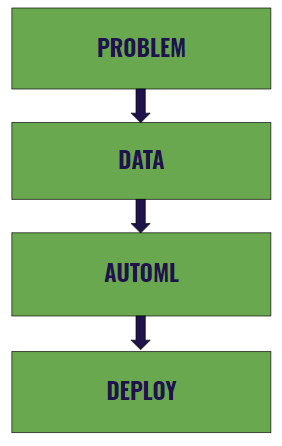

##**Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install autokeras

In [3]:
import numpy as np
import autokeras as ak
import tensorflow as tf

from keras.preprocessing import image

#**DATA**

##**Load and prepare data**

Dataset:

https://github.com/ieee8023/covid-chestxray-dataset

How did I splitted the data and organized the directories:

https://github.com/amandafbri/xray-view-position-classifier/blob/main/mount_csv.py


AutoKeras [`image_dataset_from_directory`](https://autokeras.com/utils/) is equivalent to [`ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) from Keras, so let's use it.

In [4]:
train_directory = '/content/drive/MyDrive/Estudo/Colab Notebooks/data/xray_view_position/Train'
validation_directory = '/content/drive/MyDrive/Estudo/Colab Notebooks/data/xray_view_position/Validation'
test_directory = '/content/drive/MyDrive/Estudo/Colab Notebooks/data/xray_view_position/Test'

In [5]:
# Configurable parameters
train_batch_size = 128
validation_test_batch_size = 32
img_height = 512
img_width = 512

# Set seed to ensure the same split when loading testing data.
seed = 123

train_data = ak.image_dataset_from_directory(
    train_directory,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=train_batch_size,
)

validation_data = ak.image_dataset_from_directory(
    validation_directory,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=validation_test_batch_size,
)

test_data = ak.image_dataset_from_directory(
    test_directory,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=validation_test_batch_size,
)

Found 692 files belonging to 4 classes.
Found 86 files belonging to 4 classes.
Found 87 files belonging to 4 classes.


In [61]:
train_data

<BatchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>

#**AUTOML**

##**Create and train the model**

AutoKeras automatically detects a lot of the [classifier parameters](https://autokeras.com/image_classifier/), but it is always recommended to pass them explicitly for more transparency and understanding of what is going on.

In [34]:
clf = ak.ImageClassifier(
    max_trials=1,
    directory='/content/drive/MyDrive/Estudo/Colab Notebooks/xray_view_classifier_v2',
    objective='val_loss',
    seed=seed,
    num_classes=4,
    multi_label=False,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'AUC']
)

The `fit` method search for the best model and hyperparameters. It also has a default `Early Stopping` method (10 epochs of patience).

In [35]:
clf.fit(
    x=train_data,
    epochs=10,
    validation_data=validation_data,
    verbose=1
)

Trial 1 Complete [00h 16m 07s]
val_loss: 0.996360182762146

Best val_loss So Far: 0.996360182762146
Total elapsed time: 00h 16m 07s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
Not enough memory, reduce batch size to 64.
Epoch 1/10
Not enough memory, reduce batch size to 32.
Epoch 1/10
22/22 [==============================] - 83s 3s/step - loss: 18.3137 - accuracy: 0.4523 - auc: 0.6774 - val_loss: 1.0195 - val_accuracy: 0.4651 - val_auc: 0.8044
Epoch 2/10
22/22 [==============================] - 83s 3s/step - loss: 0.7102 - accuracy: 0.7197 - auc: 0.9148 - val_loss: 0.7956 - val_accuracy: 0.6047 - val_auc: 0.8784
Epoch 3/10
22/22 [==============================] - 83s 3s/step - loss: 0.3045 - accuracy: 0.9118 - auc: 0.9880 - val_loss: 0.8701 - val_accuracy: 0.6279 - val_auc: 0.8765
Epoch 4/10
22/22 [==============================] - 83s 3s/step - loss: 0.1133 - accuracy: 0.9783 - auc: 0.9979 - val_loss: 1.0394 - val_accuracy: 0.5930 - val_auc: 0.8609
Epoch 5/10
22/22 [=============

It took 16 minutes for the first trial with best `val_loss` equals to 0.99

In [36]:
best_model = clf.tuner.get_best_model()

In [38]:
best_model.save('/content/drive/MyDrive/Estudo/Colab Notebooks/xray_view_classifier_v2/bestmodel_v2.h5')

##**Loading the trained model**

Let's take a look into our best model trained by AutoKeras!

In [40]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/Estudo/Colab Notebooks/xray_view_classifier_v2/bestmodel_v2.tf')

In [41]:
trained_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 512, 512, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 512, 512, 3)       7         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 508, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 254, 254, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 254, 254, 64)      0     

In [44]:
trained_model.get_config()

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 512, 512, 3),
    'dtype': 'float32',
    'name': 'input_1',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Custom>CastToFloat32',
   'config': {'dtype': 'float32',
    'name': 'cast_to_float32',
    'trainable': True},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'cast_to_float32'},
  {'class_name': 'Normalization',
   'config': {'axis': (-1,),
    'dtype': 'float32',
    'name': 'normalization',
    'trainable': True},
   'inbound_nodes': [[['cast_to_float32', 0, 0, {}]]],
   'name': 'normalization'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype':

In [46]:
trained_model.get_layer('cast_to_float32')

##**Predicting**

In [51]:
img = image.load_img('/content/drive/MyDrive/Estudo/Colab Notebooks/data/xray_view_position/Test/L/covid-19-caso-91-2-13.png', target_size=(512,512))
img_in_array = image.img_to_array(img)
img_in_array_expanded = np.expand_dims(img_in_array, axis=0)

It's important to note that the expanded dimension is necessary to pass through the model, because it represents the batch size parameter (even though you'll pass just one image).

In [58]:
img_in_array_expanded.shape

(1, 512, 512, 3)

In [59]:
classes = trained_model.predict(img_in_array_expanded, batch_size=validation_test_batch_size)

It predicted correctly as a X-ray with lateral view position!

In [60]:
classes.round()

array([[0., 0., 1., 0.]], dtype=float32)

#**DEPLOY**

There are a lot of possibilities here and some free resources, but first we need to create our simple API.